In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.interpolate import interp1d
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df1 = pd.read_csv("data/group1.csv")
#add a column to df1 with the value 1   
df1["group"] = 1
df2 = pd.read_csv("data/group2_filtered.csv")
#add a column to df2 with the value 2
df2["group"] = 2
#concatenate the two dataframes
df = pd.concat([df1, df2], ignore_index=True)
#sort the dataframe by the task number
df = df.sort_values(by="task number")
#reset the index
df = df.reset_index(drop=True)
#get fst  value and add it in the right task number 
fst = pd.read_csv("data/fst.csv")
# Merge on 'task number'
df = pd.merge(df, fst, on="task number", how="left")

#print the dataframe
df.head(10)

,name,task number,estimation 1,estimation 2,group,fst
0,Pierre-Francois,Task 1,30.0,28.0,1,7
1,Jessica,Task 1,28.0,29.0,1,7
2,Adam,Task 1,35.0,28.0,1,7
3,Asher,Task 1,27.0,28.0,1,7
4,Omer,Task 1,25.5,25.5,2,7
5,Uttara,Task 1,NaN,30.0,2,7
6,Kamile,Task 1,25.0,25.5,2,7
7,Pierre-Francois,Task 2,55.0,45.0,1,42
8,Jessica,Task 2,40.0,41.0,1,42
9,Adam,Task 2,35.0,35.0,1,42


In [3]:
avg_by_task = df.groupby("task number")["estimation 2"].mean()
print(avg_by_task)

task number
Task 1    27.714286
Task 2    35.571429
Task 3    35.400000
Task 4    48.200000
Task 5    58.200000
Name: estimation 2, dtype: float64


- We used Bayesian inference with a monotonic constraint by parameterizing 𝑓 f as cumulative sums of nonnegative increments.
- Each observed 
(
𝑥
𝑖
,
𝑦
𝑖
)
 enters the likelihood with a varying standard deviation (derived from the confidence interval).
- The resulting posterior distribution of 
𝑓 respects monotonicity, while weighting points with smaller CI more strongly.
- You can extend this idea to piecewise linear segments (if you want continuity between data points) or even a fully continuous monotonic spline. However, the core principle is always the same: nondecreasing increments + weighted likelihood for each data point.

In [4]:


# ---------------------------------
# 1) Prepare data
# ---------------------------------
# Get unique task numbers and their corresponding fst values
x = df['fst'].unique()
# Calculate mean estimation 2 for each task
y = df.groupby('task number')['estimation 2'].mean().values #add

# Calculate confidence intervals
ci = []
for task in df['task number'].unique():
    task_data = df[df['task number'] == task]['estimation 2']
    std_err = task_data.std() / np.sqrt(len(task_data))
    ci.append(1.96 * std_err)  # 95% confidence interval
ci = np.array(ci)

x = np.insert(x, 0, 0)  # Add 0 at the beginning
y = np.insert(y, 0, 25)
ci = np.insert(ci, 0, 0.01)

print(x)
print(y)
print(ci)

# For simplicity, let's approximate the standard deviation for each point.
# If ci is half-width of a 95% CI, then roughly:
#    95% CI = mean ± 1.96*sigma
# => half-width ~ 1.96*sigma
# => sigma ~ half-width / 1.96
sigma = ci / 1.96

# Ensure x is sorted. (It already is in this example.)
# If it weren't sorted, we'd sort x,y,sigma together.

# ---------------------------------
# 2) Define a PyMC model
# ---------------------------------
with pm.Model() as monotonic_model:
    # Intercept: f(x_0)
    intercept = pm.Normal("intercept", mu=0, sigma=100)
    
    # We have (n-1) increments for n points. Each increment >= 0 (HalfNormal ensures positivity).
    increments = pm.HalfNormal("increments", sigma=10, shape=len(x)-1)
    
    # f_vals[i] = intercept + sum(increments[:i])
    # so f(x_0) = intercept
    #    f(x_1) = intercept + increments[0]
    #    f(x_2) = intercept + increments[0] + increments[1]
    # ... and so on ...
    f_vals = pm.Deterministic(
        "f_vals",
        intercept + pm.math.cumsum(pm.math.concatenate([[0], increments]))
    )
    
    # Likelihood: each observed y_i ~ Normal(f_vals[i], sigma[i])
    pm.Normal("obs", mu=f_vals, sigma=sigma, observed=y)
    
    # ---------------------------------
    # 3) Sample from the posterior
    # ---------------------------------
    trace = pm.sample(1000, tune=1000, target_accept=0.95, random_seed=42)


[  0   7  42 123 244 330]
[25.         27.71428571 35.57142857 35.4        48.2        58.2       ]
[1.00000000e-02 1.24434722e+00 6.01620035e+00 5.93203641e+00
 1.22934350e+01 1.62620953e+01]


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, increments]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 128 seconds.


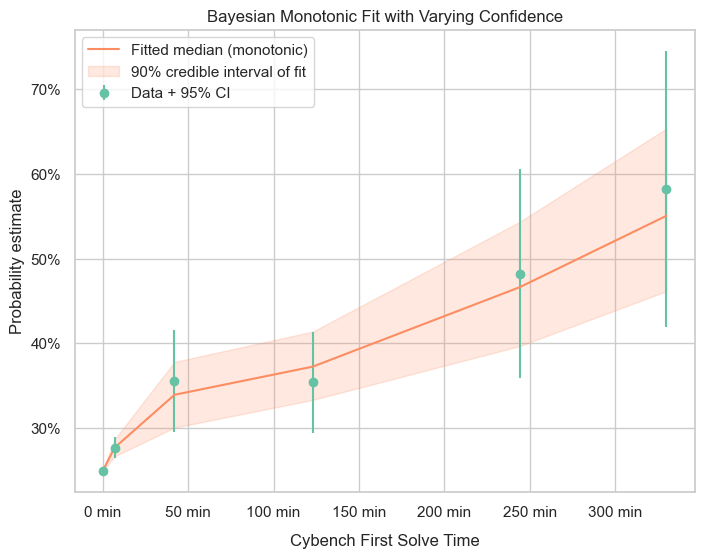

In [8]:
# # After sampling:
# with monotonic_model:
#     # Summaries of the posterior
#     az.plot_trace(trace)
#     plt.show()

#     print(az.summary(trace, var_names=["intercept", "increments", "f_vals"]))

# Posterior predictive: compute f_vals for each sample
sns.set_theme(style="whitegrid", palette="Set2")
f_samples = trace.posterior["f_vals"].values  # shape: (chain, draw, n_points)

# Let's visualize the median and credible interval for the fitted monotonic function
median_f = np.median(f_samples, axis=(0,1))   # median across all chains/draws
lower_f = np.percentile(f_samples, 5, axis=(0,1))
upper_f = np.percentile(f_samples, 95, axis=(0,1))

plt.figure(figsize=(8,6))


plt.errorbar(x, y, yerr=ci, fmt='o', label="Data + 95% CI")
plt.plot(x, median_f, label="Fitted median (monotonic)", color="C1")
plt.fill_between(x, lower_f, upper_f, alpha=0.2, color="C1",
                 label="90% credible interval of fit")

plt.xlabel("Cybench First Solve Time", labelpad=10)  # Added labelpad to move label down
plt.ylabel("Probability estimate")
plt.title("Bayesian Monotonic Fit with Varying Confidence")
plt.legend(loc='upper left')

# Format y-axis ticks to include % symbol
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x)}%"))
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f"{int(x)} min"))

#save the plot
plt.savefig("interpolation_vizualisation.png")


plt.show()
